## Example Usage
Here, we illustrate how to run TPLS on synthetic data.

In [1]:
# Necessary imports
import util
import algorithms as alg
import numpy as np
import matplotlib.pyplot as plt

### SYSTEM SETTINGS 

In [2]:
T = 200  # Time series length
K = 8  # Total available features
p = 5  # True model order
var_y = 0.5  # Observation noise variance
var_h = 1  # Feature noise variance
var_t = 0.5  # Theta noise variance

### SYNTHETIC DATA

In [3]:
# Generate data and add gaussian noise
y, H, theta, idx_true = util.generate_data(K, p, T, var_h, var_t)
y = y + np.random.normal(0, var_y, (T, 1))

### INITIALIZE 

In [4]:
t0 = 15  # Initial data size
k = 3    # Initial number of features to use

# Indices of initial features used
init_idx = np.arange(k)
init_data = [y[:t0], H[:t0, :], init_idx]   # Package input 

# Get initial estimate
theta_init, D_init, J_init = util.initialize(init_data)

# Pack variables
init_params = [theta_init, D_init, init_idx]

# Initialize instance of TPLS and update in time once
tfit = alg.TPLS(init_data, init_params, J_init, K, var_y)
tfit.time_update(y[t0-1], H[t0-1, init_idx])

# For tracking performance and plotting
J_pred = J_init
correct = []
incorrect = []

## Run TPLS

In [5]:
# Update with every new data point
for t in range(t0+1, T):

    # Receive new data point
    data_t = y[t]
    features_t = H[t, :]

    # TPLS model update step
    tfit.model_update(data_t, features_t, t)

    # TPLS time update step
    idx = tfit.selected_features_idx
    tfit.time_update(data_t, features_t[idx])

    # (OPTIONAL) Store Results
    correct.append(np.sum(np.isin(idx, idx_true)))
    incorrect.append(tfit.k - correct[-1])

    # (OPTIONAL) Predictive Error store
    J_pred = np.append(J_pred, tfit.PredError)

## PLOTS

## Feature Bar Plots

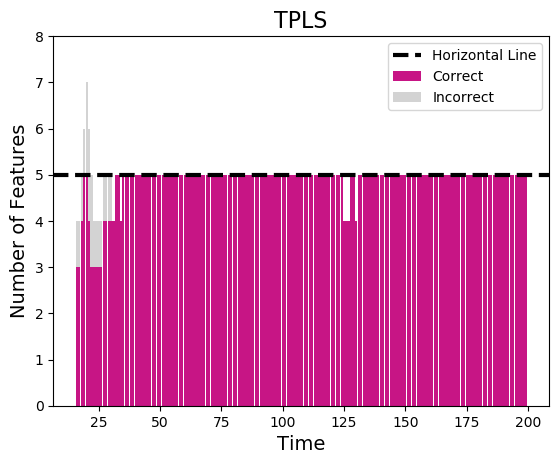

In [6]:
# Call feature bar plot 
util.bar_plot(correct, incorrect, t0,T, p, K)

## Predictive Error Plots

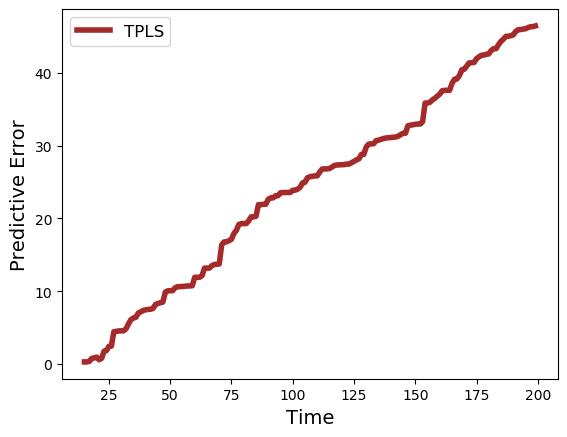

In [7]:
plt.plot(np.arange(t0,T),J_pred, linewidth=4, color='#A52A2A', label='TPLS')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Predictive Error', fontsize=14)
plt.legend(fontsize=12)

plt.show()

# Regret Analysis: MSE Adjacent Models
#### (For the interested user)
For theoretical analysis, we assume we know the true $\theta$ and exact features. 

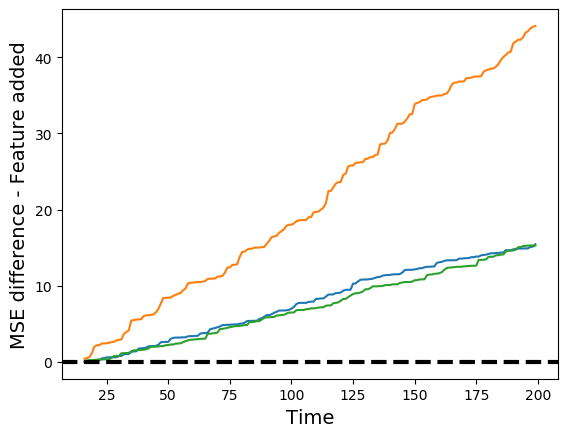

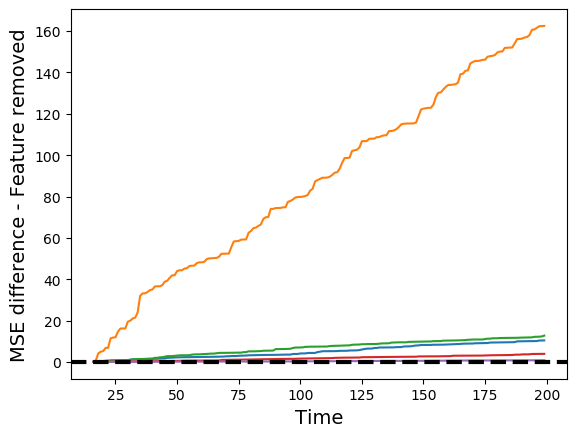

In [8]:
import LS_updates as ls

# Create instance of true model MSE
mse = ls.Expectations(y, H, t0, T, K, idx_true, var_y)

# SINGLE TIME INSTANT
# Compute MSE(Model up/down) - MSE(Model true) at single time instants n
E_up = mse.model_up()
E_down = mse.model_down()

# BATCH
E_down_batch = mse.batch(E_down)
E_up_batch = mse.batch(E_up)

# Plot for each feature added (BATCH)
# Replace variables for MSE single time instant plots
for i in range(E_up.shape[0]):
    plt.plot(np.arange(t0+1,T), E_up_batch[i, :])
plt.axhline(y=0, color='black', linestyle='--', label='Horizontal Line', linewidth=3)
plt.xlabel('Time', fontsize=14)
plt.ylabel('MSE difference - Feature added', fontsize=14)
plt.show()


for i in range(E_down.shape[0]):
    plt.plot( np.arange(t0+1,T), E_down_batch[i, :])
plt.axhline(y=0, color='black', linestyle='--', label='Horizontal Line', linewidth=3)
plt.xlabel('Time', fontsize=14)
plt.ylabel('MSE difference - Feature removed', fontsize=14)
plt.show()